<a href="https://colab.research.google.com/github/louiezzang/next-gpt/blob/main/notebooks/llama2_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Llama2


References:
- https://github.com/brevdev/notebooks/blob/main/llama2-finetune.ipynb
- https://medium.com/@geronimo7/finetuning-llama2-mistral-945f9c200611
- https://www.datacamp.com/tutorial/fine-tuning-llama-2

In [2]:
# !huggingface-cli login --token "YOUR_HF_TOKEN"
!huggingface-cli login --token "hf_XXXXX"

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [2]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
# !pip install -U accelerate bitsandbytes datasets peft transformers sentencepiece

In [4]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

# Load Dataset

In [5]:
from datasets import load_dataset

train_dataset = load_dataset("gem/viggo", split="train")
eval_dataset = load_dataset("gem/viggo", split="validation")
test_dataset = load_dataset("gem/viggo", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for gem/viggo contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/gem/viggo
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/usr/

In [6]:
print(train_dataset)
print(eval_dataset)
print(test_dataset)

Dataset({
    features: ['gem_id', 'meaning_representation', 'target', 'references'],
    num_rows: 5103
})
Dataset({
    features: ['gem_id', 'meaning_representation', 'target', 'references'],
    num_rows: 714
})
Dataset({
    features: ['gem_id', 'meaning_representation', 'target', 'references'],
    num_rows: 1083
})


# Load Base Model

In [27]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "meta-llama/Llama-2-7b-hf"
# base_model_id = "meta-llama/Llama-2-7b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load 4-bit quantized model
model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto",  # "cuda"
    # torch_dtype=torch.bfloat16,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Tokenization

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_eos_token=True,
    add_bos_token=True,
)

In [9]:
"""
# Load (slow) Tokenizer, fast tokenizer sometimes ignores added tokens
tokenizer = AutoTokenizer.from_pretrained(base_model_id, use_fast=False)

# Add tokens <|im_start|> and <|im_end|>, latter is special eos token
tokenizer.pad_token = "</s>"
tokenizer.add_tokens(["<|im_start|>"])
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))
model.resize_token_embeddings(len(tokenizer))
model.config.eos_token_id = tokenizer.eos_token_id
"""

'\n# Load (slow) Tokenizer, fast tokenizer sometimes ignores added tokens\ntokenizer = AutoTokenizer.from_pretrained(base_model_path, use_fast=False)   \n\n# Add tokens <|im_start|> and <|im_end|>, latter is special eos token \ntokenizer.pad_token = "</s>"\ntokenizer.add_tokens(["<|im_start|>"])\ntokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))\nmodel.resize_token_embeddings(len(tokenizer))\nmodel.config.eos_token_id = tokenizer.eos_token_id\n'

In [10]:
def tokenize(prompt):
    result = tokenizer(prompt)
    result["labels"] = result["input_ids"].copy()
    return result

In [11]:
def generate_and_tokenize_prompt(data_point):
    full_prompt =f"""Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
{data_point["target"]}

### Meaning representation:
{data_point["meaning_representation"]}
"""
    return tokenize(full_prompt)

In [12]:
import os

tokenized_train_dataset = train_dataset.map(
    generate_and_tokenize_prompt,
    # batched=True,
    # num_proc=os.cpu_count(), # multithreaded
)

tokenized_val_dataset = eval_dataset.map(
    generate_and_tokenize_prompt,
    # batched=True,
    # num_proc=os.cpu_count(), # multithreaded
)

In [13]:
untokenized_text = tokenizer.decode(tokenized_train_dataset[1]["input_ids"])
print(untokenized_text)

<s> Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Dirt: Showdown is a sport racing game that was released in 2012. The game is available on PlayStation, Xbox, and PC, and it has an ESRB Rating of E 10+ (for Everyone 10 and Older). However, it is not yet available as a Steam, Linux, or Mac release.

### Meaning representation:
inform(name[Dirt: Showdown], release_yea

5817


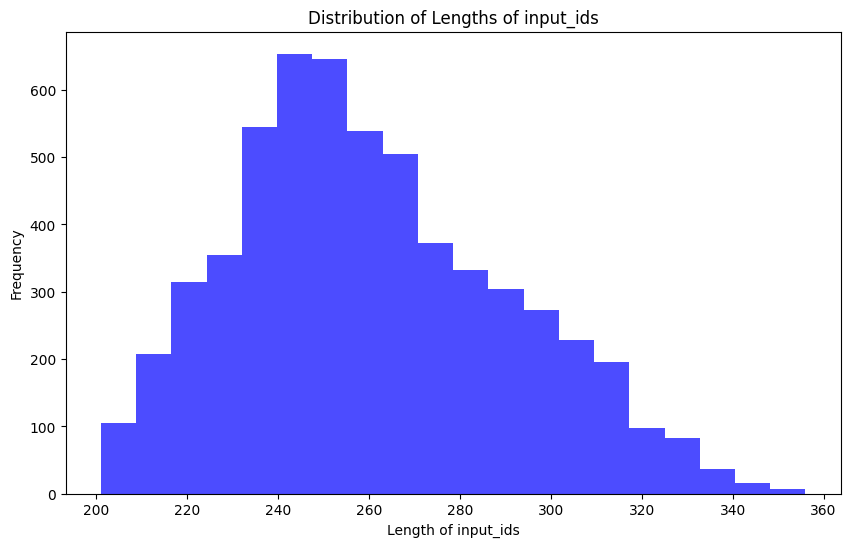

In [14]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x["input_ids"]) for x in tokenized_train_dataset]
    lengths += [len(x["input_ids"]) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color="blue")
    plt.xlabel("Length of input_ids")
    plt.ylabel("Frequency")
    plt.title("Distribution of Lengths of input_ids")
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [28]:
max_length = 340 # This was an appropriate max length for my dataset

# Redefine the tokenize function and tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token


def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [29]:
import os

tokenized_train_dataset = train_dataset.map(
    generate_and_tokenize_prompt,
    # batched=True,
    # num_proc=os.cpu_count(), # multithreaded
)

tokenized_val_dataset = eval_dataset.map(
    generate_and_tokenize_prompt,
    # batched=True,
    # num_proc=os.cpu_count(), # multithreaded
)

In [17]:
# Check that input_ids is padded on the left with the eos_token (2)
# and there is an eos_token 2 added to the end, and the prompt starts with a bos_token (1).
print(tokenized_train_dataset[4]["input_ids"])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 11221, 263, 3646, 10541, 3386, 278, 14407, 6593, 8954, 310, 278, 1881, 10541, 408, 263, 2323, 740, 411, 8393, 322, 5352, 1819, 29889, 13, 4013, 740, 881, 8453, 278, 3646, 1347, 7913, 2486, 322, 278, 740, 1818, 367, 697, 310, 278, 1494, 6024, 262, 689, 742, 525, 3827, 742, 525, 29887, 573, 29918, 459, 262, 291, 742, 525, 26897, 742, 525, 27902, 29918, 12715, 742, 525, 29879, 688, 7118, 742, 525, 3827, 29918, 735, 9018, 362, 742, 525, 276, 2055, 355, 742, 525, 3827, 29918, 12715, 13359, 13, 1576, 8393, 1818, 367, 697, 310, 278, 1494, 29901, 6024, 978, 742, 525, 4548, 29918, 14096, 29918, 1256, 742, 525, 14096, 29918, 6360, 742, 525, 6734, 742

In [18]:
# You can also untokenize to see it in plain text. It should start with <s> and end with </s>.
untokenized_text = tokenizer.decode(tokenized_train_dataset[1]["input_ids"])
print(untokenized_text)

<s> Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Dirt: Showdown is a sport racing game that was released in 2012. The game is available on PlayStation, Xbox, and PC, and it has an ESRB Rating of E 10+ (for Everyone 10 and Older). However, it is not yet available as a Steam, Linux, or Mac release.

### Meaning representation:
inform(name[Dirt: Showdown], release_yea

# Dry Run

In [19]:
print("Target Sentence: " + test_dataset[1]['target'])
print("Meaning Representation: " + test_dataset[1]['meaning_representation'] + "\n")

Target Sentence: Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?
Meaning Representation: verify_attribute(name[Little Big Adventure], rating[average], has_multiplayer[no], platforms[PlayStation])



In [20]:
eval_prompt = """Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?

### Meaning representation:
"""

In [21]:
# Re-init the tokenizer so it doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256)[0], skip_special_tokens=True))

Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?

### Meaning representation:

### Input sentence:

### Output:
The function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'ver

# Setup LoRA

In [30]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
# Add LoRA adapters to model.
model = prepare_model_for_kbit_training(model)

In [31]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [32]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRM

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by alpha/r, and thus a higher value for alpha assigns more weight to the LoRA activations.

The values used in the QLoRA paper were r=64 and `lora_alpha=16`, and these are said to generalize well, but we will use r=8 and lora_alpha=16 so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [33]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
    # modules_to_save = ["lm_head", "embed_tokens"],  # needed because we added new tokens to tokenizer/model
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)  # Why error?
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

trainable params: 20277248 || all params: 3520690176 || trainable%: 0.5759452546613406


# Train

In [34]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [35]:
# Define collate function - transform list of dictionaries [ {input_ids: [123, ..]}, {.. ] to single batch dictionary { input_ids: [..], labels: [..], attention_mask: [..] }
def collate(elements):
    tokenlist = [e["input_ids"] for e in elements]
    tokens_maxlen = max([len(t) for t in tokenlist])

    input_ids,labels,attention_masks = [],[],[]
    for tokens in tokenlist:
        pad_len = tokens_maxlen-len(tokens)

        # pad input_ids with pad_token, labels with ignore_index (-100) and set attention_mask 1 where content otherwise 0
        input_ids.append(tokens + [tokenizer.pad_token_id] * pad_len)
        labels.append(tokens + [-100]*pad_len)
        attention_masks.append([1]*len(tokens) + [0]*pad_len)

    batch={
        "input_ids": torch.tensor(input_ids),
        "labels": torch.tensor(labels),
        "attention_mask": torch.tensor(attention_masks)
    }
    return batch

In [38]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datetime import datetime

# batch_size = 1  # batch size
# ga_steps = 1  # gradient acc. steps
# epochs = 5
# steps_per_epoch = len(dataset_tokenized["train"]) // (batch_size * ga_steps)

# args = TrainingArguments(
#     output_dir="out",
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     evaluation_strategy="steps",
#     logging_steps=1,
#     eval_steps=steps_per_epoch,		# eval and save once per epoch
#     save_steps=steps_per_epoch,
#     gradient_accumulation_steps=ga_steps,
#     num_train_epochs=epochs,
#     lr_scheduler_type="constant",
#     optim="paged_adamw_32bit",
#     learning_rate=0.0002,
#     group_by_length=True,
#     fp16=True,
#     ddp_find_unused_parameters=False,
# )


project = "viggo-finetune"
base_model_name = "llama2-7b"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

args = TrainingArguments(
    output_dir=output_dir,
    warmup_steps=5,
    per_device_train_batch_size=2,
    gradient_checkpointing=True,
    gradient_accumulation_steps=4,
    max_steps=100,  # 1000
    learning_rate=2.5e-5,
    logging_steps=50,
    fp16=True,
    # bf16=True,
    optim="paged_adamw_8bit",
    logging_dir="./logs",        # Directory for storing logs
    save_strategy="steps",       # Save the model checkpoint every logging step
    save_steps=25,               # Save checkpoints every 50 steps
    evaluation_strategy="steps", # Evaluate the model every logging step
    eval_steps=50,               # Evaluate and save checkpoints every 50 steps
    do_eval=True,                # Perform evaluation at the end of training
    # report_to="wandb",
    # run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"  # Name of the W&B run (optional)
)

In [39]:
trainer = Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=args,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

trainer.train()

Step,Training Loss,Validation Loss
50,1728.213300,nan
100,389.157800,nan


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:133: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:133: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=100, training_loss=1058.68552734375, metrics={'train_runtime': 2010.7249, 'train_samples_per_second': 0.398, 'train_steps_per_second': 0.05, 'total_flos': 1.0816277250048e+16, 'train_loss': 1058.68552734375, 'epoch': 0.16})

# Inference Test

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`).

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base Llama 2 model from the Huggingface Hub:

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "meta-llama/Llama-2-7b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto", # or "auto"
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "llama2-7b-viggo-finetune/checkpoint-100")

In [6]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_eos_token=True,
    add_bos_token=True,
)

In [7]:
eval_prompt = """Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?

### Meaning representation:
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))

Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?

### Meaning representation:
 Hinweis:

- Wenn Sie das "Löschen von Daten"-Button in der Liste der Daten anzeigen, die Sie löschen möchten, verwenden, müssen 